# 2021-02-15: Calling boundaries in fly Hi-C data

I've spent some time working out some methods to computationally call boundaries in fly Hi-C data. I thought this would be more fun and useful than chugging through existing callers (almost all of which I think are looking for larger structures than I am). The original idea was to build a flexible platform that could take multiple inputs (including data taken directly from Hi-C data, ChIP data, or potentially any other genomic data such as sequence features) and some training data (presumably from hand called boundaries) and do boundary calling in a learned and probabilistic way. I'm not sure how well all this will work out, but at the moment I'm just using it on Hi-C data alone.

The guiding principle is to teach the computer to select features that I would define by eye as being boundaries. I explored a number of Hi-C derived 1D metrics and most were not super useful. The two I am currently using are the derivative of directionality and something I'm calling a geometric insulation score. Directionality is the ratio (log) of Hi-C contacts to the left and right of a position in the genome. Boundary positions are characterized by shifts from strong left-bias to right-bias (moving left to right), and these positions are readily identified by taking the first derivative (discrete difference) of the directionality vector. The geometric insulation score is comparing the Hi-C contact scores at some distance across a given genomic position to the values for the same distances immediately adjacent (but not across it). This is a bit hard to explain, but is easily understood from a geometric viewpoint (see function below), which is why I took to calling it the geometric insulation score. 

Both of these metrics do a good job of identifying boundary positions. Neither is perfect, and my hope is that using them in combination will be better than using them individually. This approach can and I hope will be improved upon continually, and that's how I have tried to set it up, as something that can be readily tweaked and improved with new inputs.

In [174]:
# Import public packages.
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi 
from importlib import reload
import pickle
import gzip
import re
import os
import pandas as pd
from scipy.ndimage import gaussian_filter
from subprocess import check_call
from pomegranate import *

# Import my packages. The order of loading is important to avoid issues on my machine.
%matplotlib inline
import matplotlib as mpl
%matplotlib notebook
%matplotlib notebook

import sys
from importlib import reload
sys.path.append('/Users/michaelstadler/Bioinformatics/Projects/insulators/bin')
from hic_jupyter import viewer
import hic_jupyter as hc

## Functions

In [32]:
def make_sample_data(files, chr_size=5e7, bin_size=500, normalize=True):
    """Convert 1D genome track files to ndarray of size (samples, features).
    
    Args:
        files: list-like
            List of 1D genome track files to put into sample data.
        chr_size: int
            Maximum size in bp of chromosomes.
        bin_size: int
            Bin size of data to use.
            
    Returns:
        X: ndarray
            ndarray of size (samples, features)
    """
    def update_maxes(chr_, bin_, chr_maxes):
        """Update maximum chromosome bins, if necessary."""
        if chr_ not in chr_maxes:
            chr_maxes[chr_] = 0
        if bin_ > chr_maxes[chr_]:
            chr_maxes[chr_] = bin_
            
    num_bins = int(chr_size // bin_size)
    sample_data = {}
    chr_maxes = {}
    
    for i in range(0, len(files)):
        file = files[i]
        if (file[-2:] == 'gz'):
            f = gzip.open(file, 'rt')
        else:
            f = open(files[i], 'r')
            
        for line in f:
            line = line.rstrip()
            chr_, bin_, val = line.split()
            val = float(val)
            bin_ = int(bin_)
            update_maxes(chr_, bin_, chr_maxes)
            if (chr_ not in sample_data):
                # Initialize array for chromosome using supplied max size.
                sample_data[chr_] = np.zeros((num_bins, len(files)))
            sample_data[chr_][bin_, i] = val
    
    # Trim chromosome arrays to extend only to maximum encountered bin.
    for chr_ in chr_maxes:
        sample_data[chr_] = sample_data[chr_][0:(chr_maxes[chr_]+1),:]

    return sample_data

In [103]:
def labels_from_hand_calls(coord_files, nudge_data, chromosome='2R', nudge_col=0, nudge_dist=2, stringency=0.66, binsize=500, buffer=5):
    """Produces a vector of labels from hand-called boundaries. Hand calls 
    are nudged to local maxima of supplied data to avoid clicking errors.
    In current implementation, training data must be on a single chromosome.
    Coordinates to not need to be contiguous; each file is added independently
    and positions between files will not be included in training data.
    
    Args:
        coordfiles: list-like
            Files containing hand-called boundary positions, format
            chromosome [tab] position1 [tab] position2
        nudge_data: dict of array-like
            Vector of data to use for nudging hand-calls to correct bins
        chromosome: str
            Chromosome used for training data
        nudge_dist: int
            Distance, in bins, on either side to search for local maximum
        stringency: float 0-1
            Within window defined by nudge_dist, bins whose value exceeds
            stringency * local maximum are labeled as boundaries.
        binsize: int
            Bin size in bp for data to use  
        buffer: int
            Number of bins to add before and after the positions of the 
            first and last boundary calls within each file
    
    Returns:
        labels: numpy array
            Labels matching chromosome positions. Unlabeled bins are -1, 
            labeled non-boundaries are 0 and boundaries are 1.
    
    """
    # Initialize labels array with chromosome size, all values -1.
    labels = np.repeat(-1, nudge_data[chromosome].shape[0])
    
    for coordfile in coord_files:
        f = open(coordfile, 'r')
        # Track the first and last bin in this file.
        bin_min = np.inf
        bin_max = -np.inf
        
        for line in f:
            line = line.rstrip()
            if (line[0] == '#'):
                pass
            else:
                chr_, pos1, pos2 = line.split()
                pos1 = float(pos1)
                pos2 = float(pos2)
                # Take the mean of the x and y coordinates as the position.
                pos = np.mean([pos1, pos2]) * 1e6
                bin_ = int(pos / binsize)
                if (bin_ > bin_max):
                    bin_max = bin_
                if (bin_ < bin_min):
                    bin_min = bin_
                
                # Define window around clicked position, find local maximum, assign "0" 
                # to bins over threshold defined by stringency and local max.
                window_start = bin_ - nudge_dist
                window_end = bin_ + nudge_dist
                local_max = np.max(nudge_data[chromosome][window_start:(window_end+1), nudge_col])
                # Toss hand call if region is masked.
                if (local_max > 0):
                    thresh = local_max * stringency
                    for i in range(window_start, window_end+1):
                        val = nudge_data[chromosome][i, nudge_col]
                        if (val >= thresh):
                            labels[i] = 0
        # Add 1 to all the positions between the first and last bins in the file
        # (with some buffer bins). Boundaries become 1, non-boundaries become 0,
        # and unlabeled regions remain -1.
        labels[(bin_min-buffer):(bin_max+buffer+1)] += 1         
        f.close()
        
    return labels



In [5]:
# Load 1D coverage data.
def load_track_data(trackfile_path):
    """Load genomic track data."""
    track_binsize = 500
    track_data = {}
    with gzip.open(trackfile_path, 'rt') as infile:
        for line in infile:
            items = line.split()
            (chr_, bin_, val) = items
            chr_ = re.sub('chr', '', chr_)
            if (chr_ not in track_data):
                track_data[chr_] = np.zeros(int(1e8 / 500))
            bin_ = int(bin_)
            if (bin_ < len(track_data[chr_])):
                track_data[chr_][bin_] = float(val)
    return track_data

In [183]:
def boundary_score_directionality(infolder, outfilepath, windowsize=75, sigma=1, mode='derivative', difference_offset=1, binsize=500, nan_buffersize=3, chr_max_size=1e8):
    """Compute directionality scores (or its derivative) for each position in the genome.
    
    Args:
        infolder: filepath
            Folder containing Hi-C data panels
        outfilepath: filepath
            Output file
        windowsize: int
            Size, in bins, of window on each side of diagonal to use in computing 
            directionality.
        sigma: numeric
            Sigma value of gaussian smoothing of output data, set to 0 for no smoothing.
        mode: str
            "directionality" computes directionality data, "derivative" returns the 
            first difference of directionality.
        difference_offset: int
            Offset for computing difference scores in derivative mode. Set to 1,
            computes distance of adjacent bins.
        binsize: int
            Bin size in bp of input data
        nan_buffersize: int
            If less than 70% of nan_buffersize adjacent bins (left and right) are non-nan values,
            score is set to 0
        chr_max_size: int
            Maximum allowable size in bp of input chromosomes (for memory purposes)
    """
    
    def not_valid_file(filename):
        """Determine if file is a viewer file."""
        if (re.search('txt.gz', filename)):
            name_items = re.sub('.txt.gz', '', filename)
            if (len(name_items.split('_')) == 4):
                return False
        return True
    
    def add_panel(infolder, filename, scores, windowsize, binsize, chr_maxes, chr_max_bins, nan_buffersize):
        """Add data from a Hi-C panel file, compute directionality within covered region."""
        # Set minimum number of non-nan values required within the buffer window.
        min_nonnan = 0.7 * nan_buffersize
        # Decide if a valid panel file.
        if not_valid_file(filename):
            return
        x = np.genfromtxt(os.path.join(infolder, filename))
        # I don't remember why this is important...it may not be.
        x[x == 0] = 0.5
        
        # Extract chromosome, positions, binsize from filename.
        name_items = re.sub('.txt.gz', '', filename)
        chr_, start, end, file_binsize = name_items.split('_')
        start_bin = int(int(start) / binsize)
        end_bin = int(int(end) / binsize)
        
        if (int(file_binsize) == binsize):
            # Handle initializing containers for new chromosomes and tracking max bins.
            if (chr_ not in scores):
                scores[chr_] = np.zeros(chr_max_bins)
            if (chr_ not in chr_maxes):
                chr_maxes[chr_] = end_bin
            if (end_bin > chr_maxes[chr_]):
                chr_maxes[chr_] = end_bin
               
            panel_size_bins = end_bin - start_bin
            for n in range(windowsize, panel_size_bins - windowsize + 1):
                # Define left and right windows, excluding the center bin.
                left_window = x[n, (n-windowsize):n]
                right_window = x[n, (n+1):(n+windowsize+1)]
                # If non-nan threshold is not met, value stays 0.
                if ((np.count_nonzero(~np.isnan(left_window[(-1 * nan_buffersize):])) > min_nonnan) and
                    (np.count_nonzero(~np.isnan(right_window[:nan_buffersize])) > min_nonnan)):
                    mean_left = np.nanmean(left_window)
                    mean_right = np.nanmean(right_window)
                    logratio = np.log(mean_right / mean_left)
                    genome_bin = start_bin + n
                    scores[chr_][genome_bin] = logratio
        
    
    chr_max_bins = int(chr_max_size // binsize)
    chr_maxes = {}
    scores = {}
    files = os.listdir(infolder)
    
    # Add all panels from input data folder.
    for file in files:
        add_panel(infolder, file, scores, windowsize, binsize, chr_maxes, chr_max_bins, nan_buffersize)
        
    outfile = open(outfilepath, 'w')
    for chr_ in chr_maxes.keys():
        if mode == 'derivative':
            # Compute rolling average in window size 2.
            roll_avg = pd.Series(scores[chr_]).rolling(2).mean()
            # Because differences are subtracted from the left, we need rolling averages assigned
            # to the left as well. There's no way to do that in rolling function, so series is  
            # manually shifted 1 position to left.
            roll_avg = roll_avg.shift(-1)
            # Compute difference.
            scores[chr_] = roll_avg.diff(difference_offset)
            # Smooth, if indicated.
            if (sigma > 0):
                scores[chr_] = gaussian_filter(scores[chr_], sigma)
        
        # Write output file.
        for bin_ in range(0, chr_maxes[chr_]):
            score = scores[chr_][bin_]
            if (score != 0):
                outfile.write(chr_ + '\t' + str(bin_) + '\t' + str(score) + '\n')
    outfile.close()
    check_call(['gzip', outfilepath])

In [182]:
import re
import os
import pandas as pd
import gzip

def boundary_score_geometric(infolder, outfilepath, dist=4, binsize=500, sigma=1, chr_max_size=1e8):
    """Compute "geometric" insulation score at each position in genome.
    
    distance = 3
    X = self
    I = insulated bin
    U = uninsulated bin
    - = diagonal
    
    - 0 0 U 0 X 0 0 0 0 0
    0 - 0 0 U X 0 0 0 0 0
    0 0 - 0 0 X 0 0 0 0 0
    0 0 0 - 0 X I 0 0 0 0
    0 0 0 0 - X 0 I 0 0 0
    X X X X X - X X X X X
    0 0 0 0 0 X - 0 0 U 0
    0 0 0 0 0 X 0 - 0 0 U
    0 0 0 0 0 X 0 0 - 0 0
    0 0 0 0 0 X 0 0 0 - 0
    0 0 0 0 0 X 0 0 0 0 -
    
    Args:
        infolder: filepath
            Folder containing Hi-C data panels
        outfilepath: filepath
            Output file
        dist: int
            Distance from the diagonal to use for calculation, in bins
        binsize: int
            Bin size in bp of input data
        sigma: numeric
            Sigma value of gaussian smoothing of output data, set to 0 for no smoothing
        chr_max_size: int
            Maximum allowable size in bp of input chromosomes (for memory purposes)
    """
    
    def not_valid_file(filename):
        """Check if file is a valid panel data file."""
        if (re.search('txt.gz', filename)):
            name_items = re.sub('.txt.gz', '', filename)
            if (len(name_items.split('_')) == 4):
                return False
        return True
    
    def add_panel(infolder, filename, scores, dist, binsize, chr_maxes, chr_max_bins, insulated, noninsulated):
        """Add data from a Hi-C panel file, compute geometric insulation scores within covered region."""
        
        if not_valid_file(filename):
            return
        x = np.genfromtxt(os.path.join(infolder, filename))
        x[x == 0] = 0.5
        
        # Get chromosome, bins, and binsize from file name.
        name_items = re.sub('.txt.gz', '', filename)
        chr_, start, end, file_binsize = name_items.split('_')
        start_bin = int(int(start) / binsize)
        end_bin = int(int(end) / binsize)
        
        if (int(file_binsize) == binsize):
            # Handle initializing containers for new chromosomes and tracking max bins.
            if (chr_ not in scores):
                scores[chr_] = np.zeros(chr_max_bins)
            if (chr_ not in chr_maxes):
                chr_maxes[chr_] = end_bin
            if (end_bin > chr_maxes[chr_]):
                chr_maxes[chr_] = end_bin
            
            
            panel_size_bins = end_bin - start_bin
            for n in range(2*dist, panel_size_bins - (2*dist) + 1):
                # Grab window around center bin based on dist.
                start = n - (2*dist) + 1
                stop = n + (2*dist) 
                local_vals = x[start:stop, start:stop]
                # Use supplied masks to selected "insulated" and "noninsulated" values from the window.
                insulated_vals = local_vals[insulated]
                noninsulated_vals = local_vals[noninsulated]
                # Count the nan and non-nan values in each set, threshold on minimums.
                insulated_nan_count = np.count_nonzero(np.isnan(insulated_vals))
                insulated_nonnan_count = np.count_nonzero(~np.isnan(insulated_vals))
                noninsulated_nan_count = np.count_nonzero(np.isnan(noninsulated_vals))
                noninsulated_nonnan_count = np.count_nonzero(~np.isnan(noninsulated_vals))
                if (((insulated_nonnan_count / (insulated_nan_count + insulated_nonnan_count)) >= 0.8 ) & 
                    ((noninsulated_nonnan_count / (noninsulated_nan_count + noninsulated_nonnan_count)) >= 0.5 )):
                    # Take mean of insulated and non-insulated bins, set their log-ratio as the score.
                    mean_insulated = np.nanmean(insulated_vals)
                    mean_noninsulated = np.nanmean(noninsulated_vals)
                    logratio = np.log(mean_noninsulated / mean_insulated)
                    genome_bin = start_bin + n
                    scores[chr_][genome_bin] = logratio
        
    # Initialize data containers.
    chr_max_bins = int(chr_max_size // binsize)
    chr_maxes = {}
    scores = {}
    files = os.listdir(infolder)

    # Get size and midpoint of matrix. Size is calibrated to produce n insulated bins
    # and n non-insulated bins to both the left and right of the candidate boundary.
    size = (dist*4)-1
    midpoint = int(size/ 2)
    # Make a grid of distances to the diagonal, with positive values to upper right.
    y, x = hc.mesh_like(np.ones((size,size)), 2)
    dist_diag = x-y
    # Make masks for insulated and non-insulated points within the window based on 
    # diagonal distance and quadrant.
    insulated = (x > midpoint) & (y < midpoint) & (dist_diag == dist)
    noninsulated = ((x < midpoint) | (y > midpoint)) & (dist_diag == dist)
    
    # Compute scores for all panels in the input folder.
    for file in files:
        add_panel(infolder, file, scores, dist, binsize, chr_maxes, chr_max_bins, insulated, noninsulated)

    # Write outputs up to max bin for each chromosome.
    outfile = open(outfilepath, 'w')
    for chr_ in chr_maxes.keys():
        scores[chr_] = gaussian_filter(scores[chr_], sigma)
        for bin_ in range(0, chr_maxes[chr_]):
            score = scores[chr_][bin_]
            if (score != 0):
                outfile.write(chr_ + '\t' + str(bin_) + '\t' + str(score) + '\n')
    outfile.close()
    check_call(['gzip', outfilepath])

In [146]:
# Function to write viewer files from probabilities with a threshold.
def write_probs_to_track(probs, outfile, thresh=0):
    # Determine which column is boundary probability (always the lower mean).
    col = 0
    test_chr = list(probs.keys())[0]
    if (np.mean(probs[test_chr][:,0]) > np.mean(probs[test_chr][:,1])):
        col = 1
        
    with open(outfile, 'w') as out:
        for chr_ in probs:
            for i in range(0, len(probs[chr_])):
                val = probs[chr_][i, col]
                if val > thresh:
                    out.write(chr_ + '\t' + str(i) + '\t' + str(val) + '\n') 

## Running

In [184]:
boundary_score_directionality('/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_files/hic_53_54_hardmasked250',
                              '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_files/boundary_caller_tracks/hic_53_54_directionality_diff2.txt')

In [150]:
for n in range(3, 11):
boundary_score_geometric('/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_files/hic_53_54_hardmasked250',
                        '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_files/boundary_caller_tracks/hic_53_54_geometric_d' + str(n) + '.txt',
                        dist=n)

GridspecLayout(children=(Dropdown(description='Chrom', layout=Layout(grid_area='widget001'), options=('X', '3L…

<IPython.core.display.Javascript object>


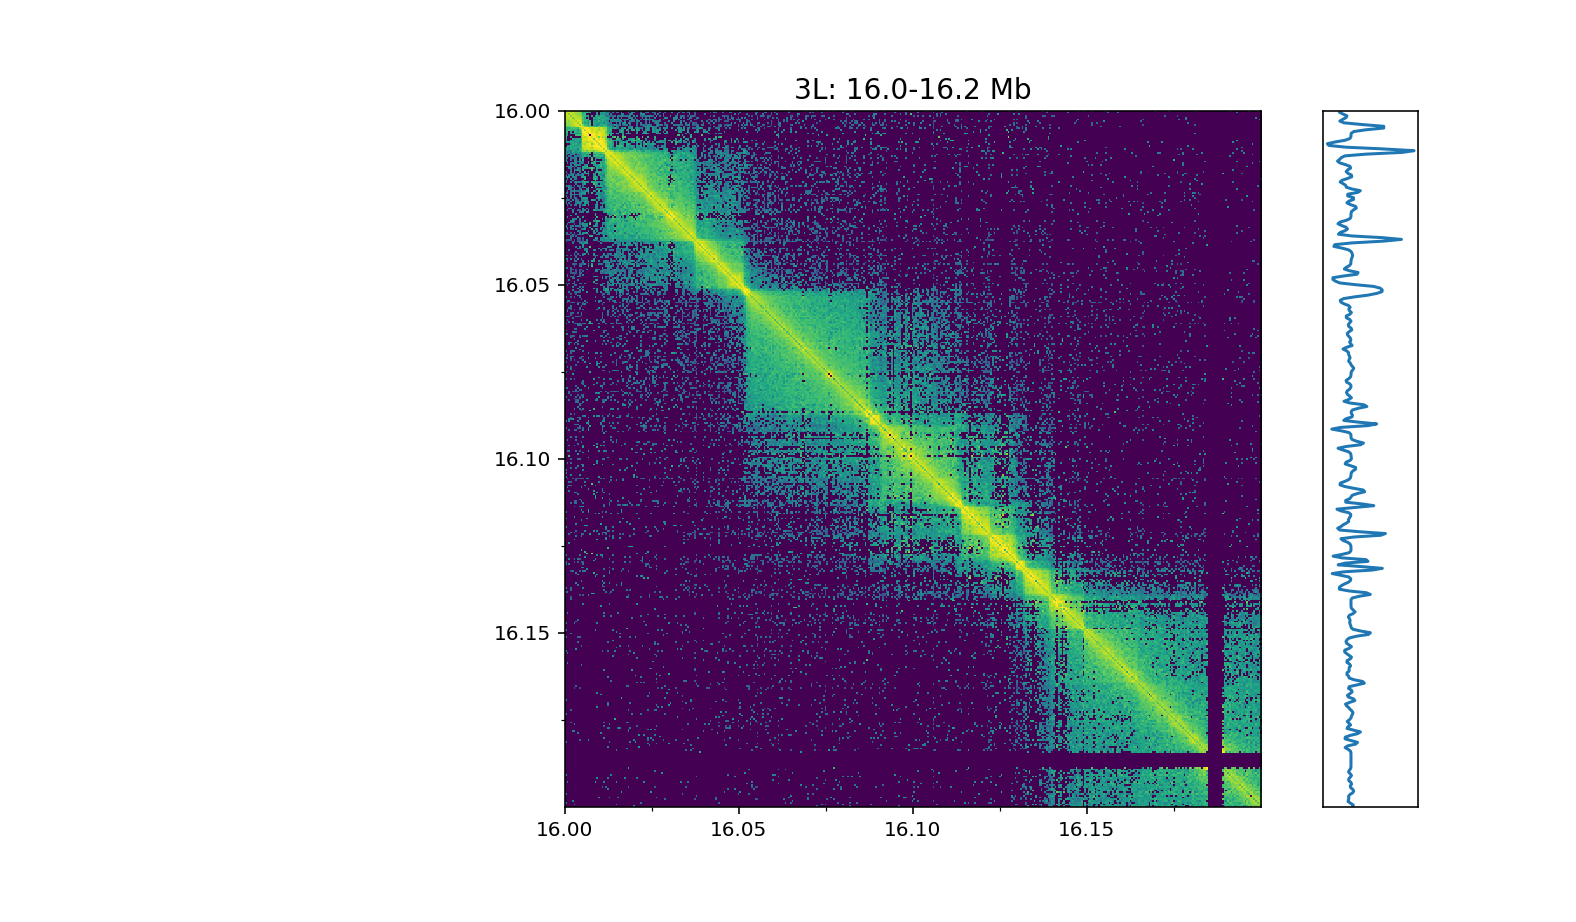

In [170]:
data_folder = '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/viewer_files/hic-53-54'
track_folder = '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_files/boundary_caller_tracks'
save_folder = '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R'
hc.viewer(data_folder, track_folder, save_folder)

In [168]:
# Load files and make training data.
data_files = ['/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_files/boundary_caller_tracks/hic_53_54_directionality_diff.txt.gz',
              '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_files/boundary_caller_tracks/hic_53_54_geometric_d4.txt.gz',
              '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_files/boundary_caller_tracks/hic_53_54_geometric_d5.txt.gz']

coord_files = ['/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_2a_clickedcoords_2021-02-02-3.txt',
          '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_2b_clickedcoords_2021-02-02-4.txt',
          '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_2c_clickedcoords_2021-02-02-2.txt'
          ]
X = make_sample_data(data_files, 5e7)
y = labels_from_hand_calls(coord_files, X,nudge_dist=3)
labeled = y != -1
x_train = X['2R'][labeled]
y_train = y[labeled]

<IPython.core.display.Javascript object>


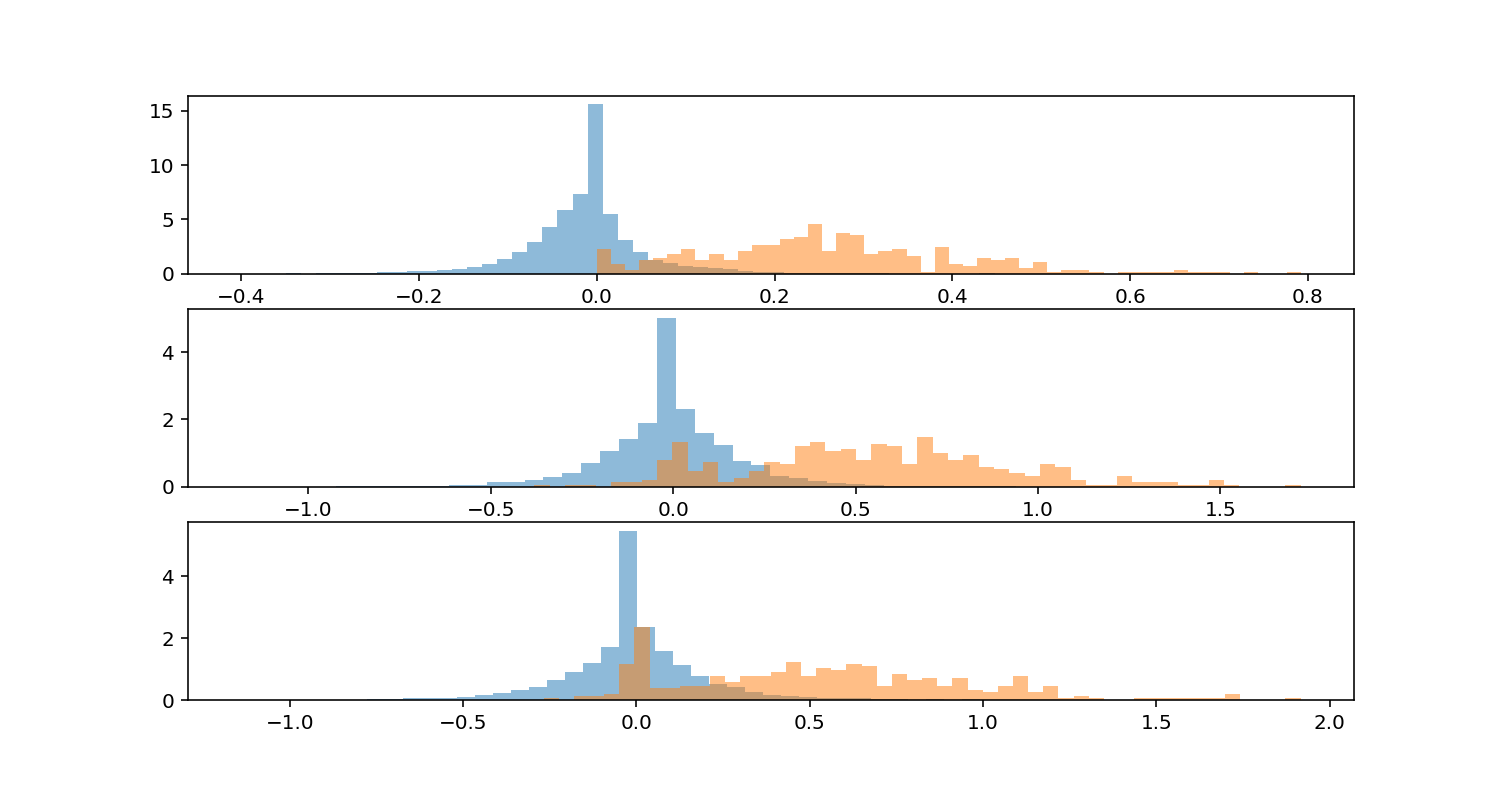

In [171]:
# Compare distributions of the scores at boundaries and non-boundaries.
plt.subplot(311)
plt.hist(x_train[:,0][y_train == 0], bins=50, density=True, alpha=0.5);
plt.hist(x_train[:,0][y_train == 1], bins=50, density=True, alpha=0.5);
plt.subplot(312)
plt.hist(x_train[:,1][y_train == 0], bins=50, density=True, alpha=0.5);
plt.hist(x_train[:,1][y_train == 1], bins=50, density=True, alpha=0.5);
plt.subplot(313)
plt.hist(x_train[:,2][y_train == 0], bins=50, density=True, alpha=0.5);
plt.hist(x_train[:,2][y_train == 1], bins=50, density=True, alpha=0.5);

<IPython.core.display.Javascript object>


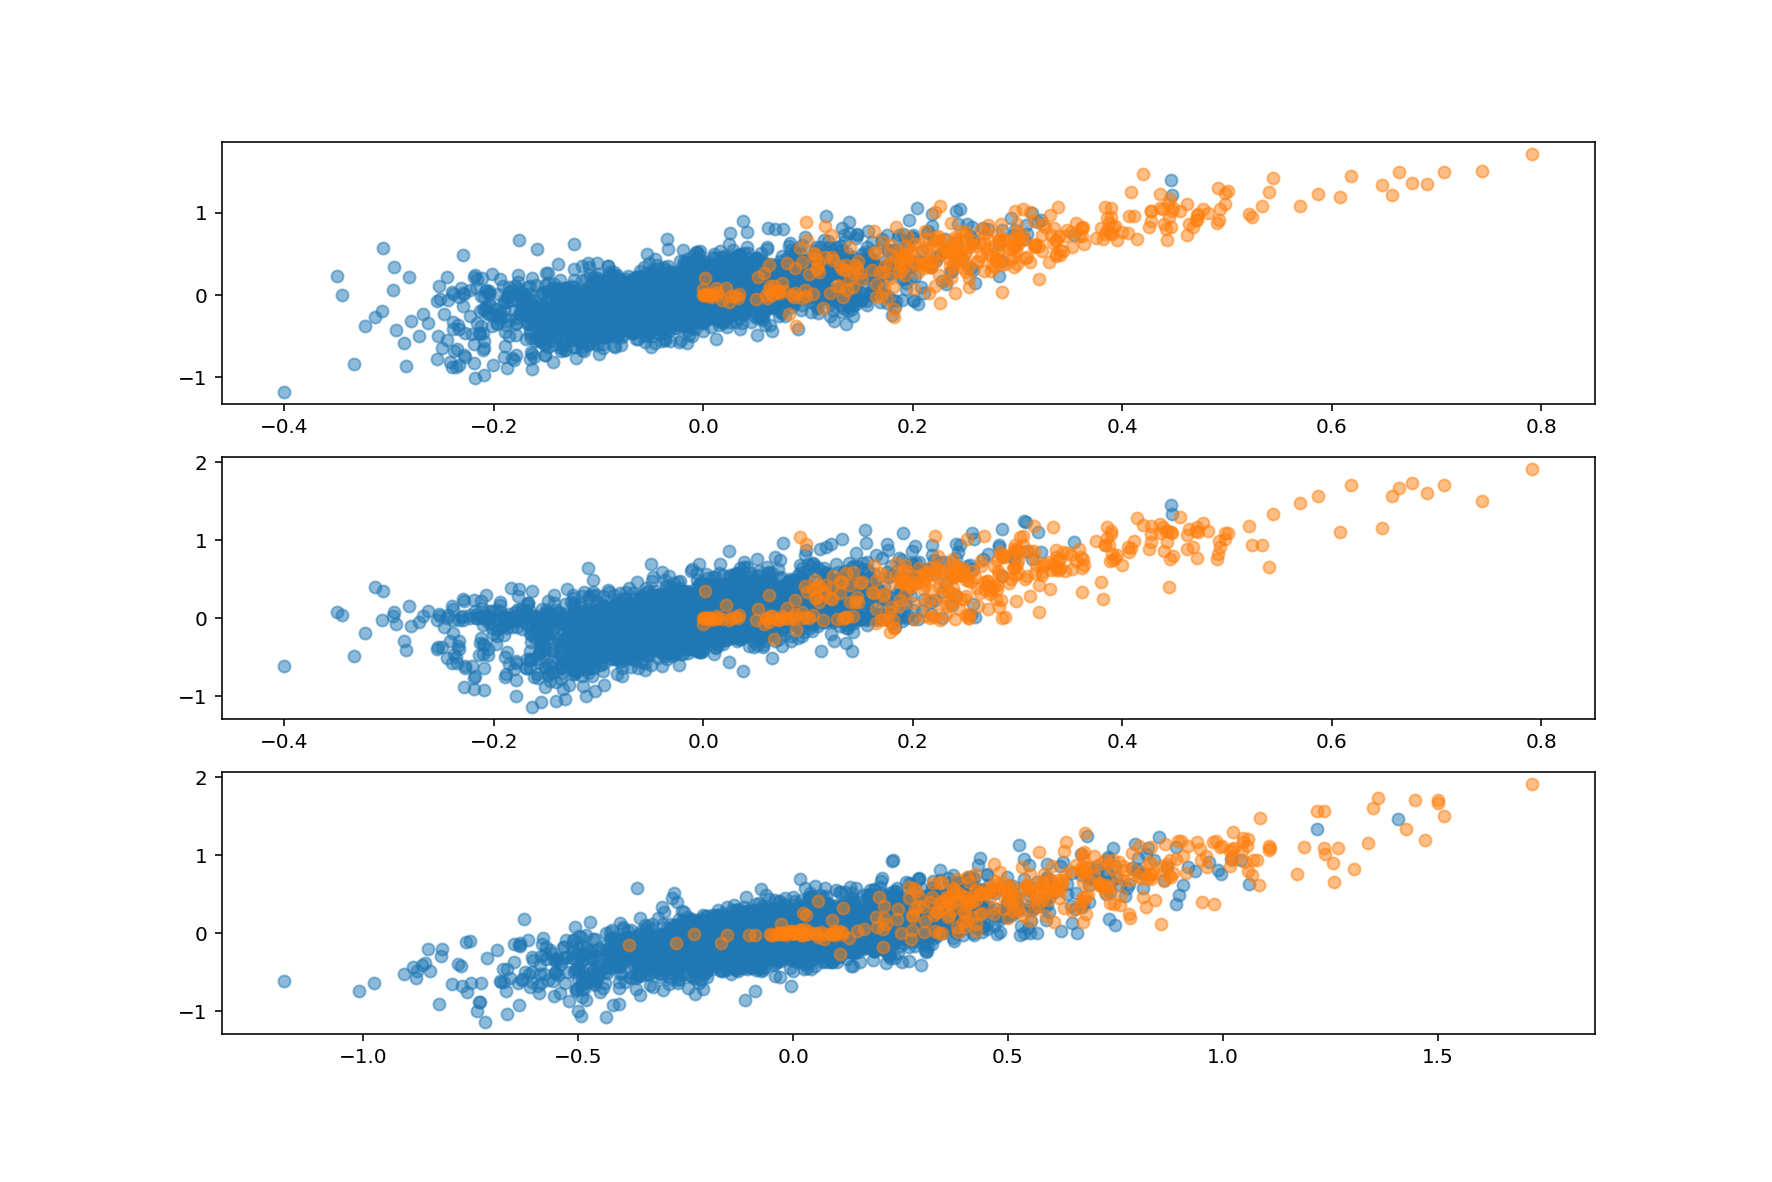

In [172]:
# Comparing the metrics to each other for non-boundaries (blue) and boundaries (orange).
plt.subplot(311)
plt.scatter(x_train[:,0][y_train == 0], x_train[:,1][y_train == 0], alpha=0.5);
plt.scatter(x_train[:,0][y_train == 1], x_train[:,1][y_train == 1], alpha=0.5);
plt.subplot(312)
plt.scatter(x_train[:,0][y_train == 0], x_train[:,2][y_train == 0], alpha=0.5);
plt.scatter(x_train[:,0][y_train == 1], x_train[:,2][y_train == 1], alpha=0.5);
plt.subplot(313)
plt.scatter(x_train[:,1][y_train == 0], x_train[:,2][y_train == 0], alpha=0.5);
plt.scatter(x_train[:,1][y_train == 1], x_train[:,2][y_train == 1], alpha=0.5);


In [188]:
# Call the whole model and write probabilities, using all 3 inputs.
outfile = '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_files/boundary_caller_tracks/boundaryprobs_test3.txt'

# Load files and make training data.
data_files = ['/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_files/boundary_caller_tracks/hic_53_54_directionality_diff.txt.gz',
              '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_files/boundary_caller_tracks/hic_53_54_geometric_d4.txt.gz',
              '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_files/boundary_caller_tracks/hic_53_54_geometric_d5.txt.gz']

coord_files = ['/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_2a_clickedcoords_2021-02-02-3.txt',
          '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_2b_clickedcoords_2021-02-02-4.txt',
          '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_2c_clickedcoords_2021-02-02-2.txt'
          ]
X = make_sample_data(data_files, 5e7)
y = labels_from_hand_calls(coord_files, X,nudge_dist=3)
labeled = y != -1
x_train = X['2R'][labeled]
y_train = y[labeled]

# Make classifier from training data, run on each chromosome, write out to file.
bayes = BayesClassifier.from_samples(MultivariateGaussianDistribution, x_train, y_train)

probs = {}
for chr_ in X:
    probs[chr_] = bayes.predict_proba(X[chr_])
    
write_probs_to_track(probs, outfile)
check_call(['gzip', outfile])

0

In [189]:
# Call the whole model and write probabilities, using all 3 inputs.
outfile = '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_files/boundary_caller_tracks/boundaryprobs_test2.txt'

# Load files and make training data.
data_files = ['/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_files/boundary_caller_tracks/hic_53_54_directionality_diff.txt.gz',
              '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/boundary_caller_files/boundary_caller_tracks/hic_53_54_geometric_d4.txt.gz']

coord_files = ['/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_2a_clickedcoords_2021-02-02-3.txt',
          '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_2b_clickedcoords_2021-02-02-4.txt',
          '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/test_2R/training_2c_clickedcoords_2021-02-02-2.txt'
          ]
X = make_sample_data(data_files, 5e7)
y = labels_from_hand_calls(coord_files, X,nudge_dist=3)
labeled = y != -1
x_train = X['2R'][labeled]
y_train = y[labeled]

# Make classifier from training data, run on each chromosome, write out to file.
bayes = BayesClassifier.from_samples(MultivariateGaussianDistribution, x_train, y_train)

probs = {}
for chr_ in X:
    probs[chr_] = bayes.predict_proba(X[chr_])
    
write_probs_to_track(probs, outfile)
check_call(['gzip', outfile])

0

GridspecLayout(children=(Dropdown(description='Chrom', layout=Layout(grid_area='widget001'), options=('X', '3L…

<IPython.core.display.Javascript object>


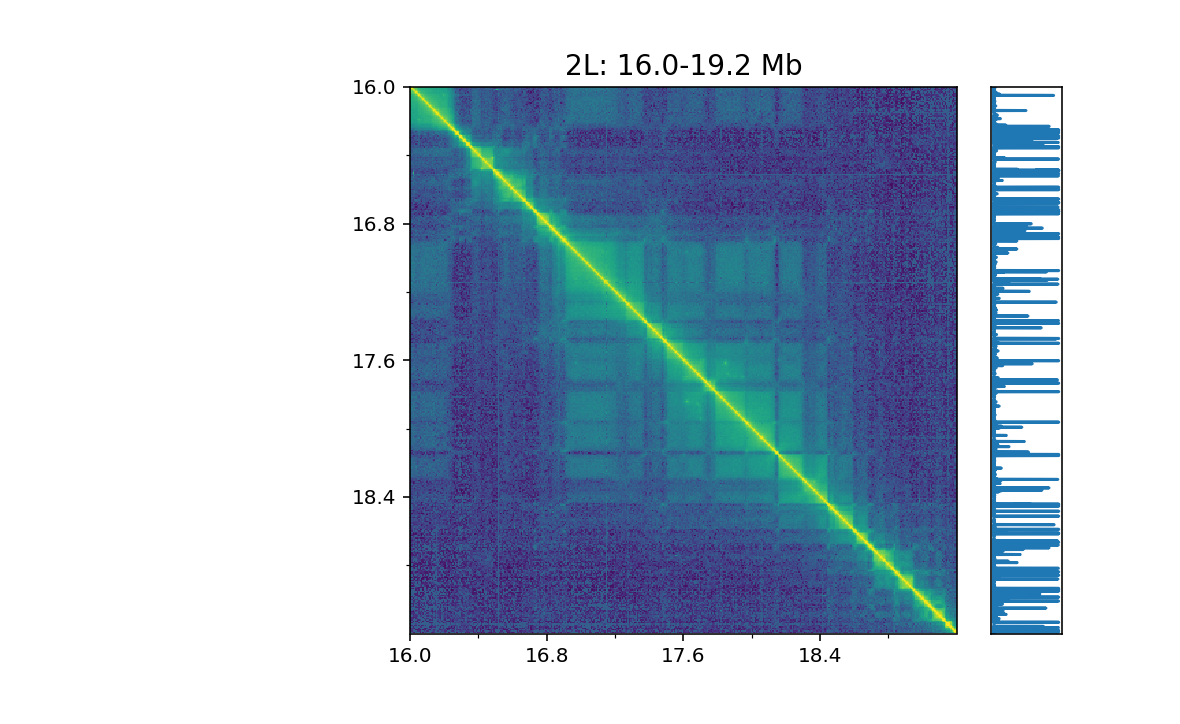

In [191]:
# Check out probabilities on the viewer.
reload(hc)
data_folder = '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/viewer_files/hic-53-54-x'
hc.viewer(data_folder, track_folder, save_folder)